In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import scipy.stats

In [2]:
def TDT(n):
    b = n[0] + n[2] + 2*n[3]
    c = n[1] + n[2] + 2*n[4]
    
    if b == 0 and c == 0:
        return 0
    else:
        return (b-c)**2/(b+c)

In [3]:
# SHD [Yamamoto and Shibuya, PSB 2022]

def SHD(cc, n):
    T = TDT(n)
    
    d = np.zeros(2)
    N = np.zeros(6)
    
    for k in range(6):
        N[k] = n[k]
    
    if T < cc:
        while T < cc:
            if N[4] > 0:
                N[4] -= 1
            elif N[1] > 0:
                N[1] -= 1
            elif N[2] > 0:
                N[2] -= 1
            elif N[5] > 0:
                N[5] -= 1
            else:
                N[0] -= 1
            N[3] += 1
            
            T = TDT(N)
            d[0] -= 1
        
        T = TDT(n)
        for k in range(6):
            N[k] = n[k]
        
        while T < cc:
            if N[3] > 0:
                N[3] -= 1
            elif N[0] > 0:
                N[0] -= 1
            elif N[2] > 0:
                N[2] -= 1
            elif N[5] > 0:
                N[5] -= 1
            else:
                N[1] -= 1
            N[4] += 1
            
            T = TDT(N)
            d[1] -= 1
        
        if d[0] > d[1]:
            return d[0]
        else:
            return d[1]
    
    else:
        step = 0
        
        if n[0] + 2*n[3] > n[1] + 2*n[4]:
            while T >= cc:
                if n[3] > 0:
                    n[3] -= 1
                elif n[0] > 0:
                    n[0] -= 1
                elif n[5] > 0:
                    n[5] -= 1
                elif n[2] > 0:
                    n[2] -= 1
                else:
                    n[1] -= 1
                n[4] += 1
            
                T = TDT(n)
                step += 1
        else:
            while T >= cc:
                if n[4] > 0:
                    n[4] -= 1
                elif n[1] > 0:
                    n[1] -= 1
                elif n[5] > 0:
                    n[5] -= 1
                elif n[2] > 0:
                    n[2] -= 1
                else:
                    n[0] -= 1
                n[3] += 1
            
                T = TDT(n)
                step += 1
        
        return step-1

In [4]:
# pseudo_SHD

def pseudo_SHD(n):
    b = n[0] + n[2] + 2*n[3]
    c = n[1] + n[2] + 2*n[4]
    
    return math.fabs(b-c)/4

In [5]:
# exponential mechanism

def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(score, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    s = np.zeros(m)
    for i in range(m):
        s[i] = score[i]
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * s[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        s[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [6]:
# (Efficient) Joint Permute-and-Flip

def JointPnF(score, m, K, epsilon):
    S = np.zeros(K)
    SS = np.zeros(K)
    w = np.zeros(m)
    
    si = np.argsort(-score)
    c = np.zeros(m)
    for i in range(m):
        c[si[i]] = i
    ss = sorted(score, reverse=True)
    for i in range(K-1,m):
        if i == K-1:
            C = 1
        else:
            C = (C/(i-K+1)) * i
        r = np.random.rand()
        if r**(1/C)==1:
            D = C
            p = 16
            while(1):
                D /= 10
                p += 1
                if r**(1/D) != 1:
                    l = (1 - r**(1/D))*(10**16)
                    break
            x = -(2/epsilon)*(math.log(l) + (-1*p)*math.log(10))
        else:
            x = -(2/epsilon)*math.log(1-r**(1/C))
        w[i] = ss[i] + x
    SS[K-1] = np.argmax(w[K-1:m]) + K-1
    SS[0:K-1] = np.random.choice(int(SS[K-1]), size=K-1, replace=False)
    
    for i in range(K):
        S[i] = c[int(SS[i])]
    
    return S

In [7]:
def generate_data(N, M):
    S = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    n = np.zeros((M,6))
    
    for i in range(M-10):
        S[i] = 2*N
        n[i][0] = np.random.binomial(S[i],1/6)
        n[i][1] = np.random.binomial((S[i]-n[i][0]), 1/5)
        n[i][2] = np.random.binomial((S[i]-n[i][0]-n[i][1]), 1/4)
        n[i][3] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]), 1/3)
        n[i][4] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]), 1/2)
        n[i][5] = S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]-n[i][4]
    
    for i in range(M-10,M):
        S[i] = 2*N
        n[i][0] = np.random.binomial(S[i],1/4)
        n[i][1] = np.random.binomial((S[i]-n[i][0]), 1/8)
        n[i][2] = np.random.binomial((S[i]-n[i][0]-n[i][1]), 1/4)
        n[i][3] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]), 1/2)
        n[i][4] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]), 1/3)
        n[i][5] = S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]-n[i][4]
    
    return n

In [8]:
def evaluation(K, N, M):
    accuracy = np.zeros((7,3))
    b = np.zeros(M)
    c = np.zeros(M)
    stats = np.zeros(M)
    
    correct = np.zeros((7,3))
    
    for j in range(50):
        n = generate_data(N,M)
        
        for i in range(M):
            stats[i] = TDT(n[i])
            
        EXACT = np.zeros(M)
        PSEUDO = np.zeros(M)
        
        x = np.argsort(-stats)
        
        cc = 19.5
        
        for i in range(M):
            a = int(x[i])
            k = [int(n[a][0]), int(n[a][1]), int(n[a][2]), int(n[a][3]), int(n[a][4]), int(n[a][5])]
            PSEUDO[i] = pseudo_SHD(k)
            EXACT[i] = SHD(cc,k)
        
        #print(simple_shd)
    
        for i in range(7):
            pseudo_shd = PSEUDO
            shd = EXACT
            if K == 7:
                shdExp_result = exp_mec(shd,M,K,i+3.2)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+3.2)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+3.2)
            if K == 5:
                shdExp_result = exp_mec(shd,M,K,i+2.2)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+2.2)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+2.2)
            if K == 3:
                shdExp_result = exp_mec(shd,M,K,i+1.4)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+1.4)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.4)
            if K == 1:
                shdExp_result = exp_mec(shd,M,K,i+0.7)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+0.7)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+0.7)
            for k in range(K):
                if shdExp_result[k] < K:
                    correct[i][0] += 1
                if pseudoExp_result[k] < K:
                    correct[i][1] += 1
                if JointPnF_result[k] < K:
                    correct[i][2] += 1
                
    accuracy = correct/(50*K)
    return accuracy

[[0.58285714 0.54857143 0.61714286]
 [0.76       0.75428571 0.91142857]
 [0.86       0.86285714 0.91428571]
 [0.90285714 0.87142857 0.94571429]
 [0.9        0.89142857 0.93142857]
 [0.91142857 0.90285714 0.94      ]
 [0.91428571 0.91714286 0.94      ]]
[[0.58       0.55714286 0.60857143]
 [0.77428571 0.79142857 0.91714286]
 [0.88285714 0.86       0.92857143]
 [0.88285714 0.88285714 0.94571429]
 [0.91142857 0.92       0.94285714]
 [0.93142857 0.92285714 0.95142857]
 [0.92285714 0.9        0.96571429]]
[[0.58285714 0.56857143 0.69714286]
 [0.81142857 0.79714286 0.89428571]
 [0.86857143 0.88857143 0.91428571]
 [0.87714286 0.90285714 0.94285714]
 [0.92       0.90285714 0.94      ]
 [0.91428571 0.93142857 0.96285714]
 [0.93714286 0.91714286 0.96857143]]
[[0.56571429 0.54       0.66285714]
 [0.78       0.78571429 0.92285714]
 [0.85142857 0.88571429 0.94      ]
 [0.88857143 0.88285714 0.93714286]
 [0.91714286 0.91714286 0.94571429]
 [0.93428571 0.90857143 0.94571429]
 [0.91428571 0.92       0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.58       0.59142857 0.67714286]
 [0.81714286 0.80857143 0.94      ]
 [0.88       0.85714286 0.93428571]
 [0.90857143 0.89428571 0.92571429]
 [0.91714286 0.91428571 0.93428571]
 [0.91142857 0.91428571 0.92857143]
 [0.92571429 0.92571429 0.93714286]]
[[0.57828571 0.56114286 0.65257143]
 [0.78857143 0.78742857 0.91714286]
 [0.86857143 0.87085714 0.92628571]
 [0.892      0.88685714 0.93942857]
 [0.91314286 0.90914286 0.93885714]
 [0.92057143 0.916      0.94571429]
 [0.92285714 0.916      0.95657143]]


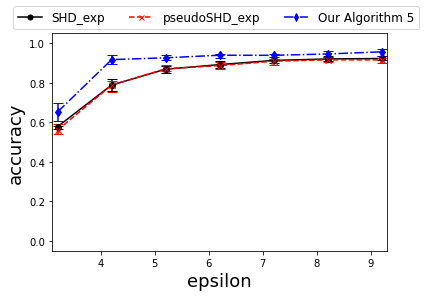

In [9]:
# n = 150, M = 5000
# K = 7

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(7,150,5000)
    for i in range(7):
        epsilon[i] = i+3.2
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(3.1, 9.3)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_TDT_K=7.png")
fig.savefig("figs/Accuracy_TDT_K=7.eps")

[[0.496 0.516 0.66 ]
 [0.752 0.792 0.86 ]
 [0.796 0.832 0.88 ]
 [0.86  0.844 0.88 ]
 [0.852 0.848 0.888]
 [0.88  0.872 0.908]
 [0.888 0.86  0.912]]
[[0.492 0.48  0.588]
 [0.772 0.804 0.84 ]
 [0.78  0.836 0.888]
 [0.848 0.9   0.88 ]
 [0.888 0.88  0.916]
 [0.86  0.86  0.904]
 [0.872 0.896 0.924]]
[[0.496 0.496 0.612]
 [0.748 0.776 0.824]
 [0.808 0.796 0.876]
 [0.86  0.872 0.876]
 [0.848 0.904 0.924]
 [0.888 0.884 0.932]
 [0.888 0.904 0.944]]
[[0.448 0.492 0.536]
 [0.78  0.756 0.868]
 [0.82  0.832 0.888]
 [0.848 0.852 0.928]
 [0.892 0.88  0.904]
 [0.908 0.888 0.944]
 [0.896 0.896 0.94 ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.476 0.504 0.456]
 [0.752 0.728 0.816]
 [0.804 0.792 0.864]
 [0.86  0.832 0.884]
 [0.852 0.856 0.896]
 [0.888 0.876 0.916]
 [0.88  0.876 0.928]]
[[0.4816 0.4976 0.5704]
 [0.7608 0.7712 0.8416]
 [0.8016 0.8176 0.8792]
 [0.8552 0.86   0.8896]
 [0.8664 0.8736 0.9056]
 [0.8848 0.876  0.9208]
 [0.8848 0.8864 0.9296]]


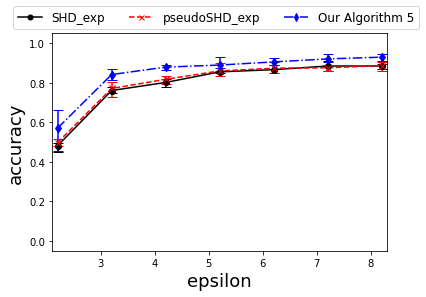

In [10]:
# n = 150, M = 5000
# K = 5

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(5,150,5000)
    for i in range(7):
        epsilon[i] = i+2.2
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(2.1, 8.3)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_TDT_K=5.png")
fig.savefig("figs/Accuracy_TDT_K=5.eps")

[[0.43333333 0.48       0.62666667]
 [0.66       0.69333333 0.77333333]
 [0.74       0.8        0.87333333]
 [0.82       0.84666667 0.89333333]
 [0.82666667 0.86       0.92      ]
 [0.89333333 0.85333333 0.92      ]
 [0.88666667 0.86       0.92      ]]
[[0.44       0.42666667 0.57333333]
 [0.7        0.73333333 0.72666667]
 [0.80666667 0.80666667 0.81333333]
 [0.84666667 0.8        0.84666667]
 [0.88666667 0.78       0.86666667]
 [0.86       0.86666667 0.88666667]
 [0.87333333 0.84666667 0.88666667]]
[[0.46       0.43333333 0.58666667]
 [0.68666667 0.72666667 0.8       ]
 [0.8        0.77333333 0.83333333]
 [0.84       0.87333333 0.9       ]
 [0.83333333 0.83333333 0.90666667]
 [0.82666667 0.86666667 0.90666667]
 [0.9        0.86666667 0.94      ]]
[[0.46       0.52       0.62      ]
 [0.72       0.74666667 0.77333333]
 [0.84       0.78666667 0.86      ]
 [0.87333333 0.83333333 0.84      ]
 [0.84       0.86       0.89333333]
 [0.9        0.86       0.9       ]
 [0.91333333 0.86666667 0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.44666667 0.41333333 0.6       ]
 [0.71333333 0.71333333 0.76666667]
 [0.82       0.80666667 0.87333333]
 [0.83333333 0.84666667 0.89333333]
 [0.84666667 0.86       0.91333333]
 [0.9        0.88666667 0.92666667]
 [0.91333333 0.86666667 0.92      ]]
[[0.448      0.45466667 0.60133333]
 [0.696      0.72266667 0.768     ]
 [0.80133333 0.79466667 0.85066667]
 [0.84266667 0.84       0.87466667]
 [0.84666667 0.83866667 0.9       ]
 [0.876      0.86666667 0.908     ]
 [0.89733333 0.86133333 0.91066667]]


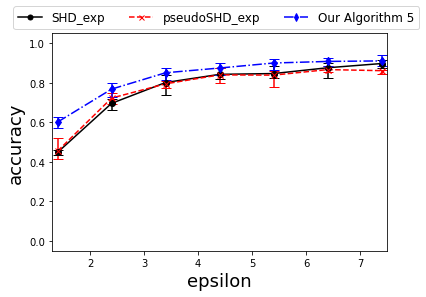

In [11]:
# n = 150, M = 5000
# K = 3

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(3,150,5000)
    for i in range(7):
        epsilon[i] = i+1.4
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(1.3, 7.5)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_TDT_K=3.png")
fig.savefig("figs/Accuracy_TDT_K=3.eps")

[[0.56 0.4  0.56]
 [0.76 0.8  0.84]
 [0.88 0.86 0.86]
 [0.82 0.9  0.88]
 [0.86 0.88 0.88]
 [0.8  0.88 0.9 ]
 [0.86 0.88 0.88]]
[[0.36 0.42 0.66]
 [0.68 0.76 0.74]
 [0.74 0.78 0.84]
 [0.8  0.86 0.86]
 [0.9  0.84 0.94]
 [0.88 0.88 0.88]
 [0.92 0.9  0.9 ]]
[[0.36 0.52 0.62]
 [0.74 0.72 0.8 ]
 [0.82 0.82 0.82]
 [0.8  0.86 0.88]
 [0.88 0.9  0.86]
 [0.88 0.9  0.88]
 [0.86 0.88 0.86]]
[[0.56 0.5  0.62]
 [0.76 0.76 0.82]
 [0.88 0.82 0.76]
 [0.88 0.8  0.9 ]
 [0.84 0.86 0.86]
 [0.92 0.86 0.86]
 [0.88 0.88 0.84]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.54 0.44 0.48]
 [0.84 0.68 0.76]
 [0.82 0.76 0.76]
 [0.86 0.84 0.78]
 [0.86 0.78 0.78]
 [0.9  0.82 0.8 ]
 [0.9  0.86 0.9 ]]
[[0.476 0.456 0.588]
 [0.756 0.744 0.792]
 [0.828 0.808 0.808]
 [0.832 0.852 0.86 ]
 [0.868 0.852 0.864]
 [0.876 0.868 0.864]
 [0.884 0.88  0.876]]


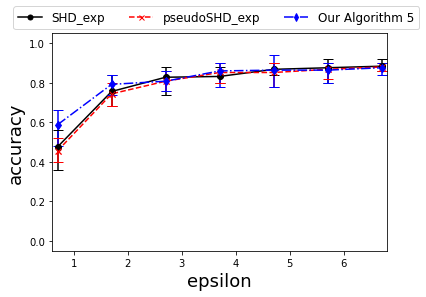

In [12]:
# n = 150, M = 5000
# K = 1

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(1,150,5000)
    for i in range(7):
        epsilon[i] = i+0.7
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(0.6, 6.8)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_TDT_K=1.png")
fig.savefig("figs/Accuracy_TDT_K=1.eps")